In [1]:
import numpy as np
from matplotlib import pyplot as plt

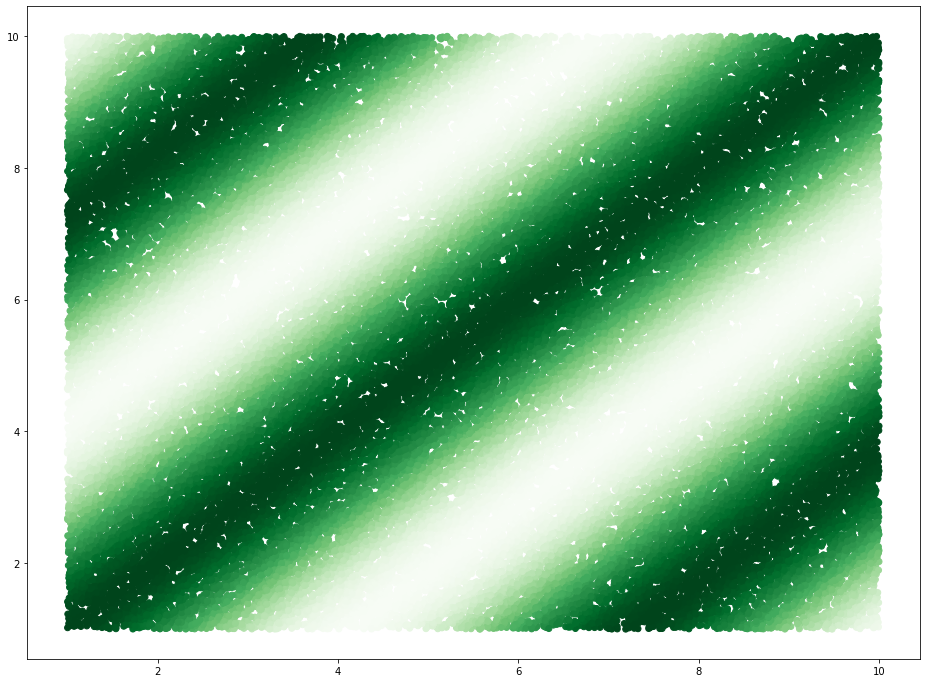

In [3]:
x = np.random.randint(1, 10, 50000) + np.random.random(50000)
y = np.random.randint(1, 10, 50000) + np.random.random(50000)
v = np.cos(x - y)
fig = plt.figure(figsize=(16, 12))
ax = plt.axes()
ax.scatter(x, y, c=v, cmap='Greens')

In [8]:
def to_image(image_np, x, y, value, width, height, dist_threshold):
    x_min, y_min = min(x), min(y)
    x_max, y_max = max(x), max(y)
    width_interval = (x_max - x_min) / width
    height_interval = (y_max - y_min) / height

    num_points = len(x)
    
    for row in range(width):
        x_point = width_interval * row + x_min
        for col in range(height):
            y_point = height_interval * col + y_min

            min_dist = 10
            min_dist_idx = 0
            for i in range(num_points):
                dist = ((x[i] - x_point) ** 2) + ((y[i] - y_point) ** 2)
                if min_dist > dist:
                    min_dist_idx = i
                    min_dist = dist

            if min_dist > dist_threshold:
                image_np[row, col] = 0
            else:
                image_np[row, col] = value[min_dist_idx]

In [9]:
image_np = np.empty((96, 96), dtype=np.float32)
to_image(image_np, x, y, v, 96, 96, 0.01)

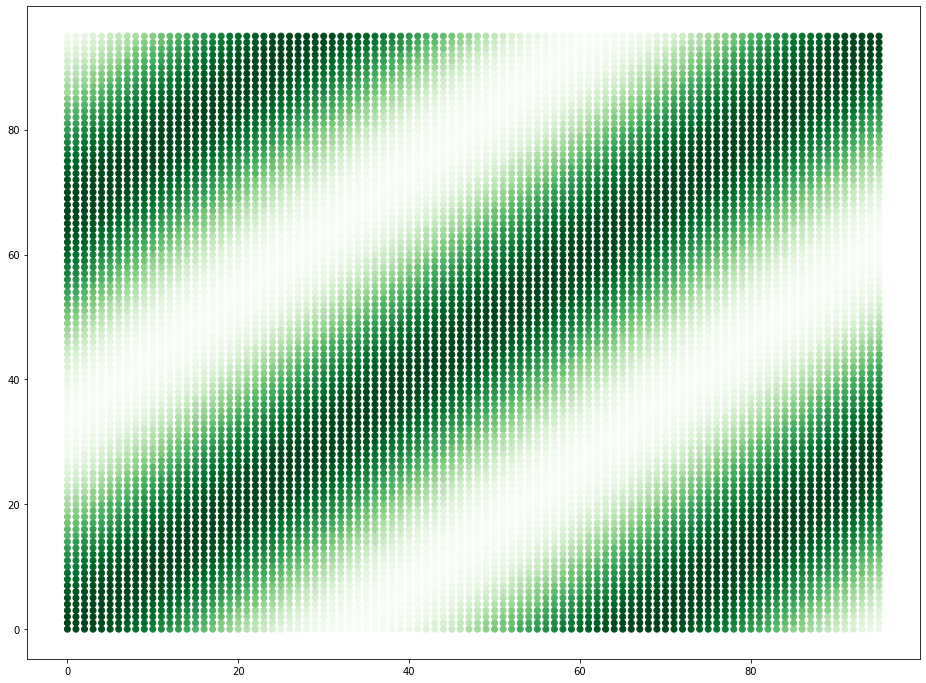

In [10]:
fig = plt.figure(figsize=(16, 12))
ax = plt.axes()
x_grid, y_grid = np.meshgrid(range(image_np.shape[0]), range(image_np.shape[1]))
ax.scatter(x_grid, y_grid, c=image_np.flatten(), cmap='Greens')

In [ ]:
def to_image(image_np, x, y, value, width, height, dist_threshold):
    x_min, y_min = min(x), min(y)
    x_max, y_max = max(x), max(y)
    width_interval = (x_max - x_min) / width
    height_interval = (y_max - y_min) / height

    for i in range(width):
        x_dist_square = [pow(x_i - (width_interval * i + x_min)) for x_i in x]
        for j in range(height):
            y_dist_square = [pow(y_i - (height_interval * j + y_min)) for y_i in y]

            for _i in range(num_points):
                dist = ((x[_i] - x_point) ** 2) + ((y[_i] - y_point) ** 2)
                if min_dist > dist:
                    min_dist_idx = _i
                    min_dist = dist

            if dist_square[nearest_points_idx] > dist_threshold:
                image_np[i, j] = 0
            else:
                image_np[i, j] = value[nearest_points_idx]

    return image_np

In [3]:
def to_image_np(x, y, value, width, height, dist_threshold):
    width_interval = (x.max() - x.min()) / width
    height_interval = (y.max() - y.min()) / height

    image_np = np.empty((width, height), dtype=np.float32)
    for i in range(width):
        x_dist_square = np.power(x - (width_interval * i + x.min()), 2)
        for j in range(height):
            y_dist_square = np.power(y - (height_interval * j + y.min()), 2)
            dist_square = x_dist_square + y_dist_square
            nearest_points_idx = np.argmin(dist_square)
            if dist_square[nearest_points_idx] > dist_threshold:
                    image_np[i, j] = 0
            else:
                image_np[i, j] = value[nearest_points_idx]

    return image_np

In [4]:
image = to_image_np(x, y, v, 320, 320, 9/50000*10)

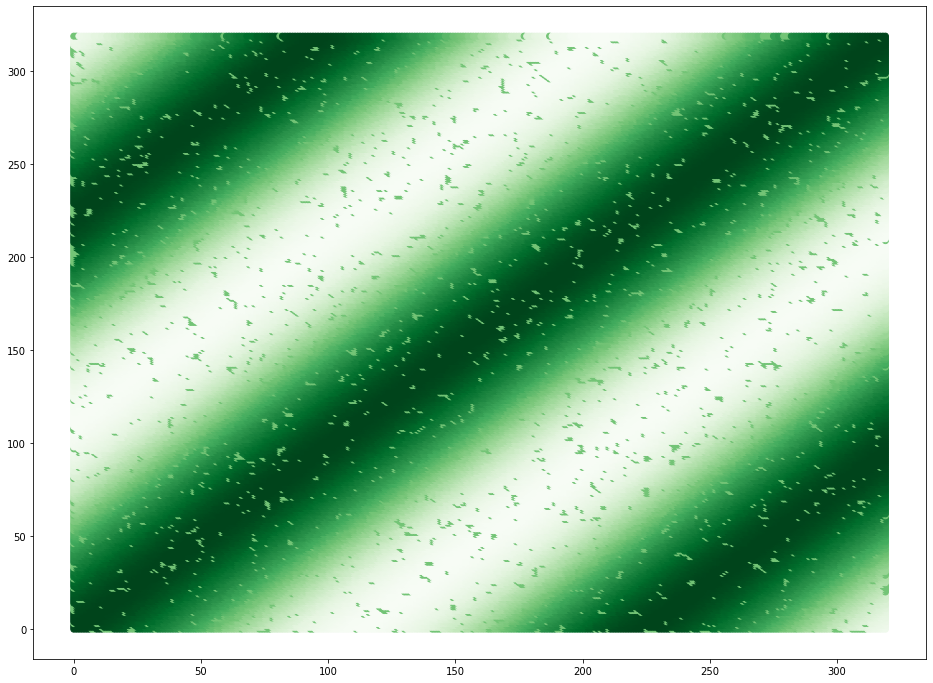

In [5]:
fig = plt.figure(figsize=(16, 12))
ax = plt.axes()
x_grid, y_grid = np.meshgrid(range(image.shape[0]), range(image.shape[1]))
ax.scatter(x_grid, y_grid, c=image.flatten(), cmap='Greens')

In [6]:
image.max(), image.min()

(1.0, -1.0)

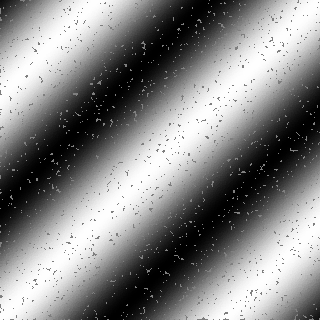

In [7]:
from PIL import Image

scale_image = ((image + 1) * 127.5).astype(np.int16)
Image.fromarray(np.rot90(scale_image)).convert('L')

In [8]:
import numba
from numba import njit, prange


@njit(numba.types.Array(numba.float32, 2, 'C')(numba.types.Array(numba.float64, 1, 'C'),
                                               numba.types.Array(numba.float64, 1, 'C'),
                                               numba.types.Array(numba.float64, 1, 'C'),
                                               numba.int64,
                                               numba.int64,
                                               numba.float64), parallel=True)
def to_image_signature(x, y, value, width, height, dist_threshold):
    width_interval = (x.max() - x.min()) / width
    height_interval = (y.max() - y.min()) / height

    image_np = np.empty((width, height), dtype=np.float32)
    for i in prange(width):
        x_dist_square = np.power(x - (width_interval * i + x.min()), 2)
        for j in prange(height):
            y_dist_square = np.power(y - (height_interval * j + y.min()), 2)
            dist_square = x_dist_square + y_dist_square
            nearest_points_idx = np.argmin(dist_square)
            if dist_square[nearest_points_idx] > dist_threshold:
                image_np[i, j] = 0
            else:
                image_np[i, j] = value[nearest_points_idx]

    return image_np

In [19]:
%timeit -n 1 image_nb = to_image_signature(x, y, v, 320, 320, 9/50000*10)

839 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


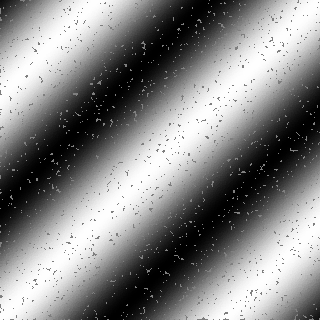

In [10]:
scale_image_nb = ((image_nb + 1) * 127.5).astype(np.int16)
Image.fromarray(np.rot90(scale_image_nb)).convert('L')

In [11]:
image_nb.max(), image_nb.min(), image_nb.shape, scale_image_nb.max(), scale_image_nb.min()

(1.0, -1.0, (320, 320), 255, 0)

In [4]:
from numba import cuda


@cuda.jit
def to_image_numba_cuda(image_np, x, y, value, x_min, y_min, width, height,
                        width_interval, height_interval):
    startX, startY = cuda.grid(2)
    gridX, gridY = cuda.gridsize(2)

    num_points = x.shape[0]
    
    for row in range(startX, width, gridX):
        x_point = width_interval * row + x_min
        for col in range(startY, height, gridY):
            y_point = height_interval * col + y_min

            min_dist = 10
            min_dist_idx = 0
            for _i in range(num_points):
                dist = ((x[_i] - x_point) ** 2) + ((y[_i] - y_point) ** 2)
                if min_dist > dist:
                    min_dist_idx = _i
                    min_dist = dist

            image_np[row, col] = value[min_dist_idx]

In [4]:
image_x = 320
image_y = 320
thread_x = 32
thread_y = 1
thread_size = (thread_x, thread_y)
block_size = ((image_x//thread_x) + 1, (image_y//thread_y) + 1)
image_nb_cuda = cuda.device_array((image_x, image_y), dtype=np.float64)

width_interval = (x.max() - x.min()) / image_x
height_interval = (y.max() - y.min()) / image_y
dist_square = cuda.device_array(len(y), dtype=np.float64)
x_cuda = cuda.to_device(x)
y_cuda = cuda.to_device(y)
v_cuda = cuda.to_device(v)

In [5]:
%timeit -n 1 to_image_numba_cuda[block_size, thread_size](image_nb_cuda, x_cuda, y_cuda, v_cuda, x.min(), y.min(), image_x, image_y, width_interval, height_interval)

The slowest run took 2144.13 times longer than the fastest. This could mean that an intermediate result is being cached.
36.5 ms ± 89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
image_x = 320
image_y = 320
thread_x = 32
thread_y = 1
thread_size = (thread_x, thread_y)
block_size = ((image_x//thread_x) + 1, (image_y//thread_y) + 1)
image_nb_cuda = cuda.device_array((image_x, image_y), dtype=np.float32)

width_interval = (x.max() - x.min()) / image_x
height_interval = (y.max() - y.min()) / image_y
x_cuda = cuda.to_device(np.float32(x))
y_cuda = cuda.to_device(np.float32(y))
v_cuda = cuda.to_device(np.float32(v))

In [7]:
%timeit -n 1 to_image_numba_cuda[block_size, thread_size](image_nb_cuda, x_cuda, y_cuda, v_cuda, x.min(), y.min(), image_x, image_y, width_interval, height_interval)

The slowest run took 2623.90 times longer than the fastest. This could mean that an intermediate result is being cached.
45.9 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


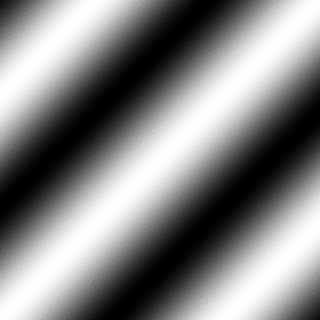

In [9]:
from PIL import Image

image_nb_np = image_nb_cuda.copy_to_host()
scale_image_nb = ((image_nb_np + 1) * 127.5).astype(np.int16)
Image.fromarray(np.rot90(scale_image_nb)).convert('L')

In [16]:
image_nb_np.max(), image_nb_np.min(), image_nb_np.shape, ((image_nb_np + 1) * 127.5).max()

(0.9999999995134298, -0.9999999999796947, (320, 320), 254.9999999379623)

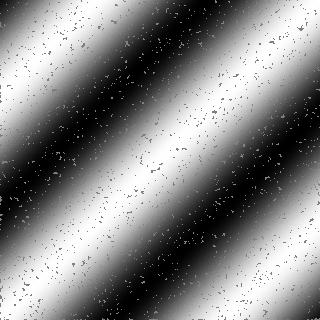

In [78]:
scale_image_nb = ((image_nb + 1) * 127.5).astype(np.int16)
Image.fromarray(np.rot90(scale_image_nb)).convert('L')

In [13]:
from time import time

times = []
fs = [to_image_np, to_image_nb, to_image_nb_signature, to_image_nb_cuda]
for f in fs:
    st = time()
    f(x, y, v, 320, 320, 9/50000*10)
    times.append(time() - st)
times

[33.9213593006134, 0.8287780284881592]

ConversionError: Failed to convert value(s) to axis units: ['cpython', 'numpy']

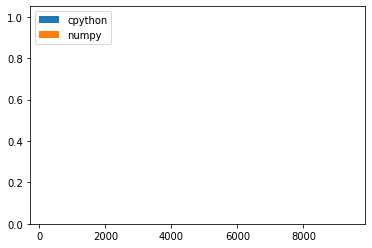

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([9400], label=['cpython'], align='left')
ax.hist([180], label=['numpy'], align='left')
plt.legend(loc='upper left')
ax.set_xticks(['cpython', 'numpy'])
ax.set_xticklabels(['cpython', 'numpy'])
plt.show()